In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras import optimizers
from keras.models import load_model
from PIL import Image

Mounting Drive

Import Libraries

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train And Test Data Path

In [ ]:
train_path = '/content/drive/MyDrive/dogAndCatDataset/sample_data/train/'
test_path = '/content/drive/MyDrive/dogAndCatDataset/sample_data/test1/'

Split Train Data Into Two Categories (Dogs And Cats)

In [ ]:
# dogs -> 1   cats -> 0
filenames=os.listdir(train_path)
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)


Make a DataFrame

In [ ]:
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [ ]:
df.head(10)

filename  category
0  dog.9099.jpg         1
1    dog.91.jpg         1
2   dog.910.jpg         1
3  dog.9100.jpg         1
4  dog.9101.jpg         1
5  dog.9102.jpg         1
6  dog.9103.jpg         1
7  dog.9104.jpg         1
8  dog.9105.jpg         1
9  dog.9106.jpg         1

Visualize Sample Train Dataset (Dogs & Cats)

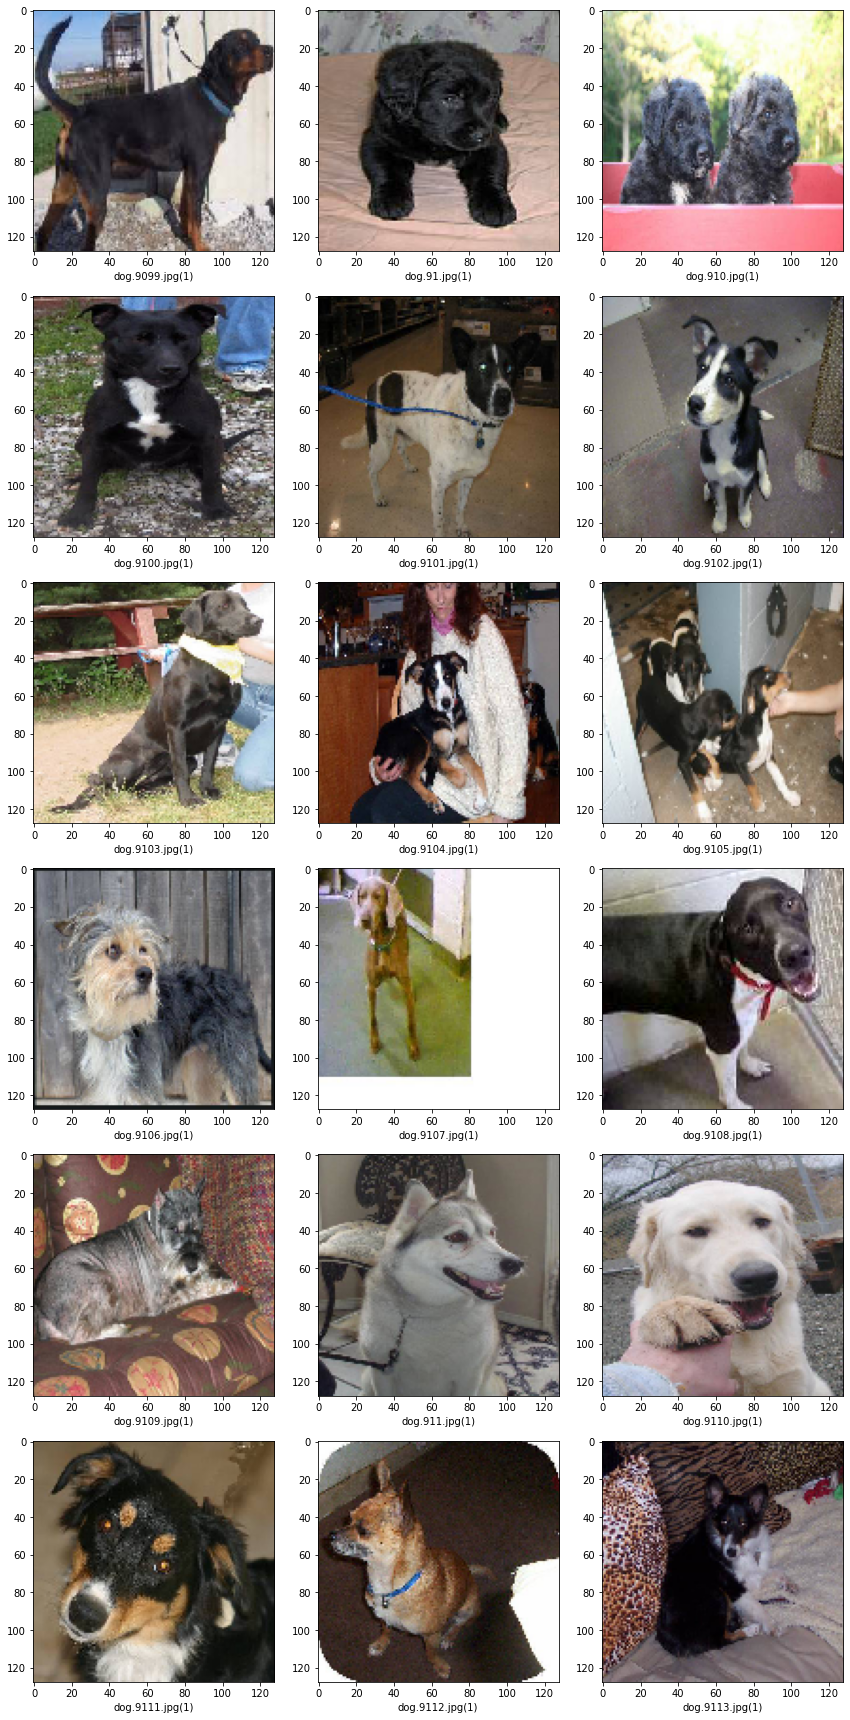

In [ ]:
sample_train = df.head(18)
plt.figure(figsize=(12, 24))
for index, row in sample_train.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(train_path +filename, target_size=(128, 128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Define Image Parameters

In [ ]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

Define Layers and Build Model (Convolutional Neural Network Model)

In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

Learning Rates and Other Essential Parameters

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

Categorize category field (0 -> Cat and 1 -> Dog)

In [ ]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})

Split Train Dataset into Train and Validation

In [ ]:
train_df,validate_df = train_test_split(df,test_size=0.20,random_state=42)
train_df = train_df.reset_index(drop=True)

In [ ]:
validate_df = validate_df.reset_index(drop=True)

In [ ]:
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

Read data from Directory and Generate Image Data

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                  rescale=1./255,
                  shear_range=0.1,
                  zoom_range=0.2,
                  horizontal_flip=True,
                  width_shift_range=0.1,
                  height_shift_range=0.1
                  )

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 train_path,x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)


Found 5000 validated image filenames belonging to 2 classes.


Model Training

In [ ]:
epochs=10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 176s 132ms/step - loss: 0.3650 - accuracy: 0.8396 - val_loss: 0.3117 - val_accuracy: 0.8711 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 174s 130ms/step - loss: 0.3568 - accuracy: 0.8434 - val_loss: 0.2893 - val_accuracy: 0.8751 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 172s 129ms/step - loss: 0.3458 - accuracy: 0.8496 - val_loss: 0.3262 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.8560
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1333/1333 [==============================] - 171s 128ms/step - loss: 0.3391 - accuracy: 0.8560 - val_loss: 0.3489 - val_accuracy: 0.8585 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - 173s 130ms/step - loss: 0.3153 - accuracy: 0.8660 - val_loss: 0.2501 - val_accuracy: 0.8973 - lr: 5.0000e-04
Epoch 6/10
1333/1333 [======

Model Prediction

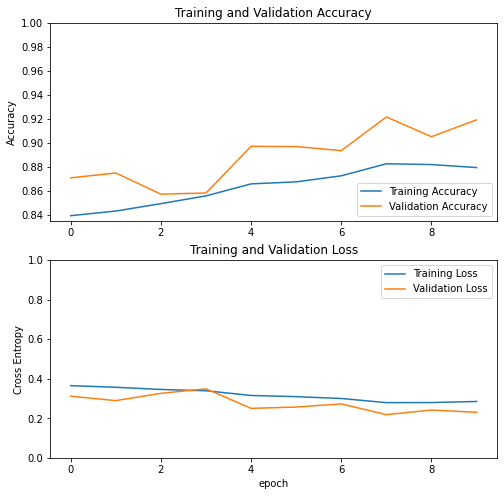

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Save the Model

In [ ]:
model.save('/content/drive/MyDrive/dogsAndCatsModel/catAndDogClassifier_epochs10.h5')

Load the saved Model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/dogsAndCatsModel/catAndDogClassifier_epochs10.h5') #same file path

Testing on new Random Test Dataset

In [ ]:
results={
    0:'cat',
    1:'dog'
}

Model Prediction Function

In [ ]:
model = load_model('/content/drive/MyDrive/dogsAndCatsModel/catAndDogClassifier_epochs10.h5')
def test_prediction(img_path):
  img_size = (128,128)
  im=Image.open(img_path)
  im=im.resize(img_size)
  im=np.expand_dims(im,axis=0)
  im=np.array(im)
  im=im/255
  pred=model.predict([im])[0]
  results={0:'cat',1:'dog'}
  return (results[np.argmax(pred)])

Make a Test Dataframe for new Dataset

In [ ]:
full_paths = list()
for file_name in os.listdir(test_path):
    full_path = os.path.join(test_path, file_name)
    full_paths.append(full_path)

test_df = pd.DataFrame() 
test_df['image_path'] = full_paths     
test_df = test_df.head(20)

Predict row wise and save result to respective row

In [ ]:
test_df['category_pred'] = test_df.apply(lambda row: test_prediction(row['image_path']), axis=1)

Print 10 rows of Test DataFrame

In [ ]:
test_df.head(10)

image_path category_pred
0  /content/drive/MyDrive/dogAndCatDataset/sample...           dog
1  /content/drive/MyDrive/dogAndCatDataset/sample...           cat
2  /content/drive/MyDrive/dogAndCatDataset/sample...           cat
3  /content/drive/MyDrive/dogAndCatDataset/sample...           cat
4  /content/drive/MyDrive/dogAndCatDataset/sample...           dog
5  /content/drive/MyDrive/dogAndCatDataset/sample...           dog
6  /content/drive/MyDrive/dogAndCatDataset/sample...           cat
7  /content/drive/MyDrive/dogAndCatDataset/sample...           dog
8  /content/drive/MyDrive/dogAndCatDataset/sample...           dog
9  /content/drive/MyDrive/dogAndCatDataset/sample...           dog

Visualize that Test Dataset and Check whether our prediction is Right or Wrong

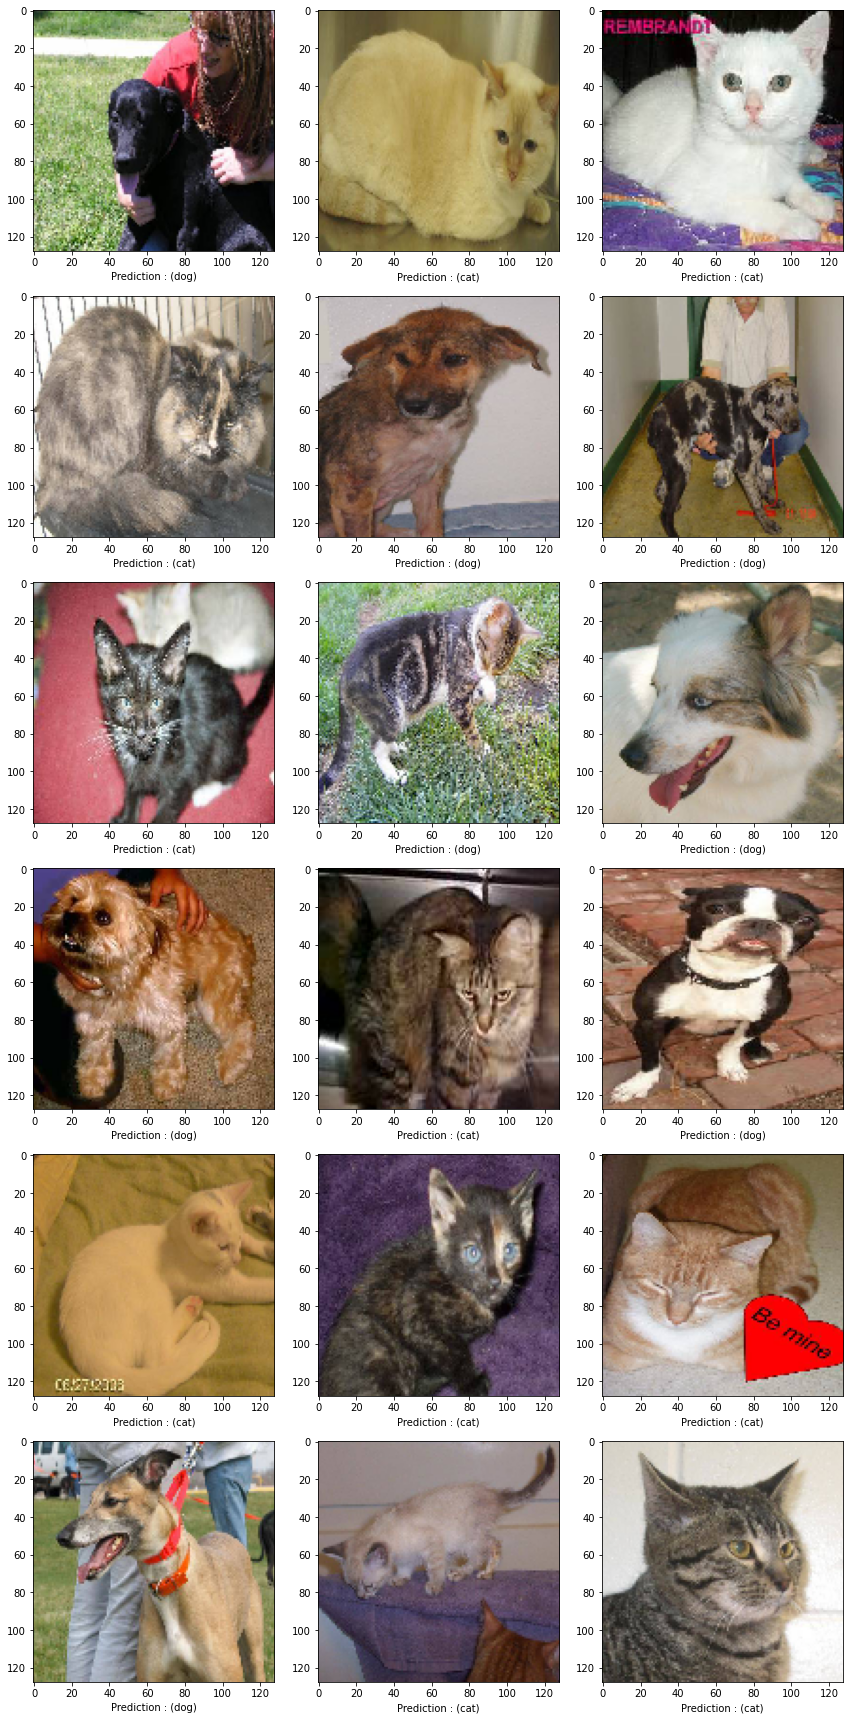

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    category = row['category_pred']
    img = load_img(row['image_path'], target_size=(128,128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('Prediction : (' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Thank You!